In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import squeezenet1_0
from google.colab import drive
import os

drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
pip install torchattack

In [29]:
from torchattack import PGD

In [30]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

model_configs = [
    ('Std LeNet', 'lenet.pth', 'lenet'),
    ('Std Squeeze', 'squeezenet.pth', 'squeezenet'),
    ('Rob LeNet', 'lenet_robust.pth', 'lenet'),
    ('Rob Squeeze', 'squeezenet_robust.pth', 'squeezenet')
]

In [31]:
def get_train_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    return torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=True)

def train_zoo_model(arch_cls, robust=False, epochs=3):
    model = arch_cls().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    loader = get_train_loader()

    model.train()
    for epoch in range(epochs):
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            if robust:
                model.eval()
                adv_imgs = PGD(model, eps=0.3, steps=3, alpha=0.1)(imgs, lbls)
                model.train()
                imgs = torch.cat([imgs, adv_imgs])
                lbls = torch.cat([lbls, lbls])

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, lbls)
            loss.backward()
            optimizer.step()
    model.eval()
    return model

In [32]:
print("Training Evaluation Zoo...")
zoo_models = {
    'MLP_Std': train_zoo_model(SimpleMLP, robust=False),
    'MLP_Rob': train_zoo_model(SimpleMLP, robust=True),
    'CNN_Std': train_zoo_model(SimpleCNN, robust=False),
    'CNN_Rob': train_zoo_model(SimpleCNN, robust=True),
}
print("Zoo Ready.")

Training Evaluation Zoo...
Zoo Ready.


In [33]:
base_path = '/content/drive/My Drive/adversarial_mnist'
adv_dir = f'{base_path}/large_adversarial_examples'
ext_data_path = f'{base_path}/external_dataset/mnist_fgsm_test.csv'

ext_imgs, ext_lbls = None, None
if os.path.exists(ext_data_path):
    df = pd.read_csv(ext_data_path)
    ext_lbls = torch.tensor(df.iloc[:, 0].values).long()
    ext_imgs = torch.tensor(df.iloc[:, 1:].values).float().reshape(-1, 1, 28, 28) / 255.0
    ext_imgs, ext_lbls = ext_imgs.to(device), ext_lbls.to(device)

In [34]:
def evaluate(model, imgs, lbls):
    if model is None: return 0
    with torch.no_grad():
        preds = model(imgs.to(device)).argmax(1)
        return (preds == lbls.to(device)).float().mean().item() * 100

offense_vs_std = []
offense_vs_rob = []
l2_costs = []

for name, fname, _ in model_configs:
    path = f"{adv_dir}/500_adv_{fname}"
    if not os.path.exists(path):
        offense_vs_std.append(0); offense_vs_rob.append(0); l2_costs.append(0)
        continue

    data = torch.load(path)
    adv_imgs = data['adv']
    adv_lbls = data['lbl']
    l2_costs.append(data['avg_l2'])

    scores_std = [evaluate(zoo_models['MLP_Std'], adv_imgs, adv_lbls),
                  evaluate(zoo_models['CNN_Std'], adv_imgs, adv_lbls)]
    offense_vs_std.append(100 - np.mean(scores_std))

    scores_rob = [evaluate(zoo_models['MLP_Rob'], adv_imgs, adv_lbls),
                  evaluate(zoo_models['CNN_Rob'], adv_imgs, adv_lbls)]
    offense_vs_rob.append(100 - np.mean(scores_rob))

from torchvision.models import squeezenet1_0
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5); self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120); self.fc2 = nn.Linear(120, 84); self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1); x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x)); return self.fc3(x)

class SqueezeNetMNIST(nn.Module):
    def __init__(self):
        super(SqueezeNetMNIST, self).__init__()
        self.model = squeezenet1_0(num_classes=10)
        self.model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
    def forward(self, x):
        if x.shape[1] == 1: x = x.repeat(1, 3, 1, 1)
        return self.model(x)

defense_scores = []
for _, fname, arch in model_configs:
    m = LeNet5() if arch == 'lenet' else SqueezeNetMNIST()
    path = f"{base_path}/model_weights/{fname}"
    if os.path.exists(path):
        m.load_state_dict(torch.load(path, map_location=device))
        m.to(device).eval()
        if ext_imgs is not None:
            defense_scores.append(evaluate(m, ext_imgs, ext_lbls))
        else:
            defense_scores.append(0)
    else:
        defense_scores.append(0)

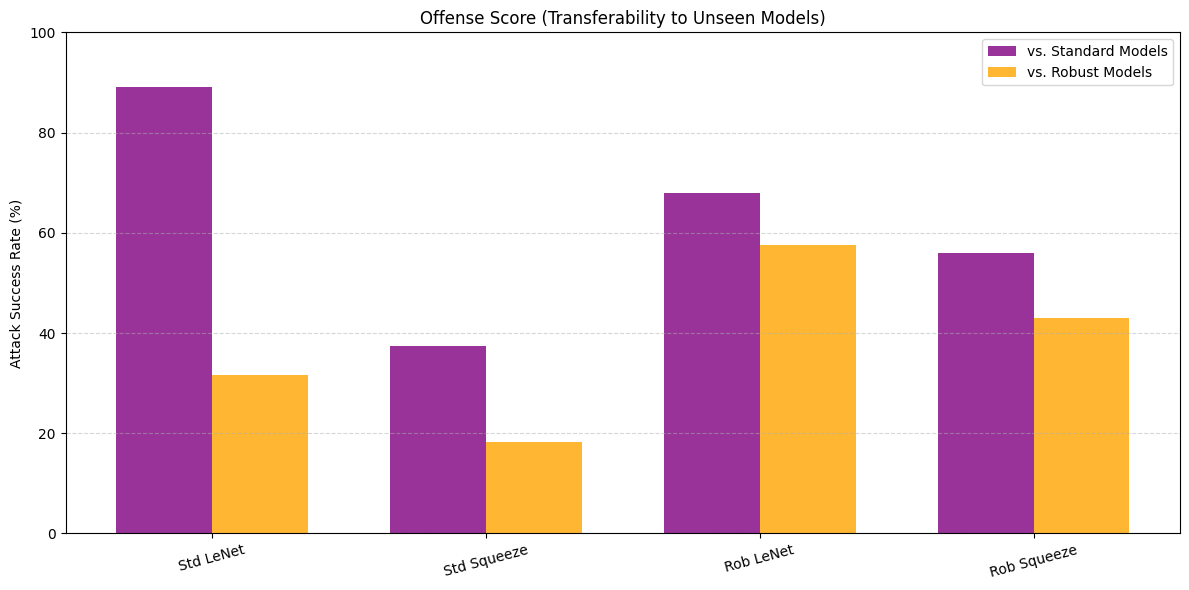

In [35]:
names = [c[0] for c in model_configs]
x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, offense_vs_std, width, label='vs. Standard Models', color='purple', alpha=0.8)
plt.bar(x + width/2, offense_vs_rob, width, label='vs. Robust Models', color='orange', alpha=0.8)
plt.xticks(x, names, rotation=15)
plt.ylabel("Attack Success Rate (%)")
plt.title("Offense Score (Transferability to Unseen Models)")
plt.legend()
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

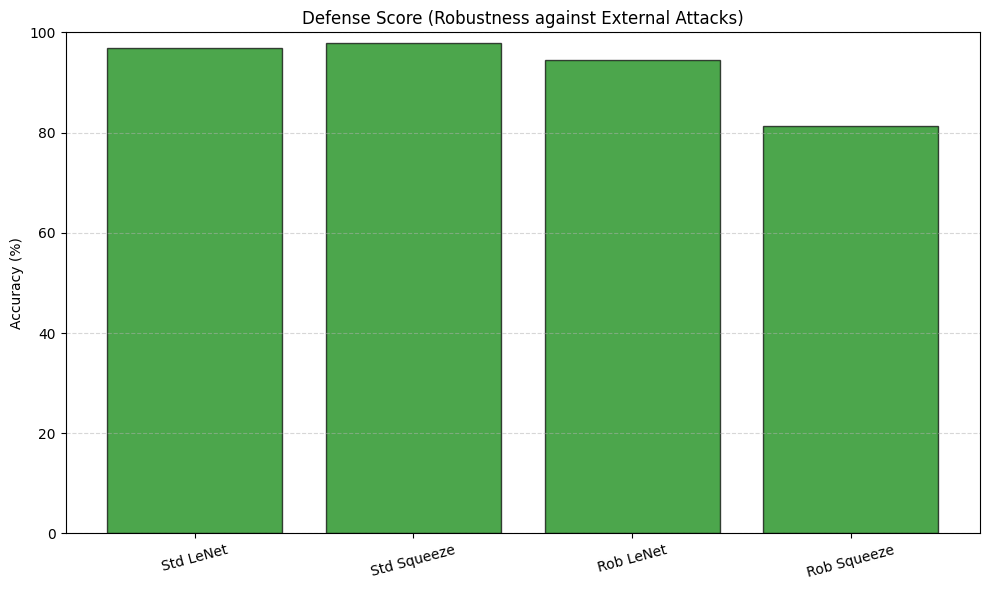

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(x, defense_scores, color='green', alpha=0.7, edgecolor='black')
plt.xticks(x, names, rotation=15)
plt.ylabel("Accuracy (%)")
plt.title("Defense Score (Robustness against External Attacks)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

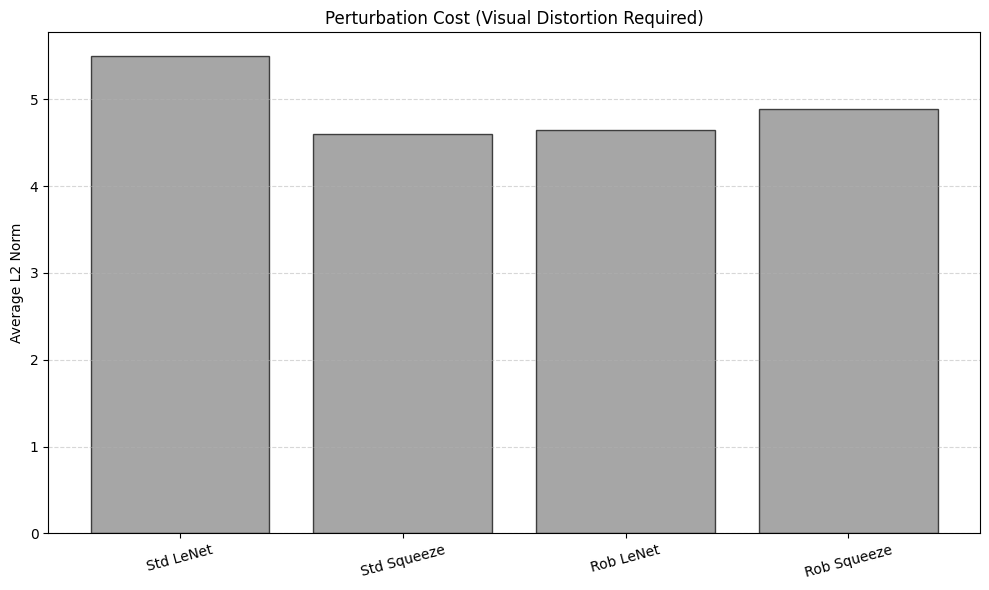

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(x, l2_costs, color='gray', alpha=0.7, edgecolor='black')
plt.xticks(x, names, rotation=15)
plt.ylabel("Average L2 Norm")
plt.title("Perturbation Cost (Visual Distortion Required)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [38]:
matrix_original = np.zeros((4, 4))

print("Generating Original Cross-Comparison Matrix...")

for i, (src_name, src_fname, _) in enumerate(model_configs):
    path = f"{adv_dir}/500_adv_{src_fname}"
    if not os.path.exists(path):
        continue

    data = torch.load(path)
    adv_imgs = data['adv']
    adv_lbls = data['lbl']

    for j, target_model in enumerate(models):
        acc = evaluate(target_model, adv_imgs, adv_lbls)
        matrix_original[i, j] = acc

plt.figure(figsize=(10, 8))
sns.heatmap(matrix_original, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=names, yticklabels=names)
plt.title("Original Cross-Comparison Heatmap (Accuracy %)\n(Rows: Attack Source | Cols: Target Model)")
plt.ylabel("Source Model (Attacker)")
plt.xlabel("Target Model (Victim)")
plt.tight_layout()
plt.show()

Generating Original Cross-Comparison Matrix...


NameError: name 'models' is not defined